# Project 4: Volume Strategy

## Introduction
This project investigates trading strategies based on volume indicators. The goal is to evaluate the impact of volume-based strategies on trading performance.

## Table of Contents
1. Introduction
2. Data Collection
3. Volume Strategy Development
4. Backtesting and Results
5. Conclusion
6. References

### **Late December 2022**

# Volume Stategy

I remember that everything always went wrong in this strategy. I remember being frious, quitting numerous times when realising that the strategy had som index error or that the logic was flawed.

Anyways, here is the strategy:

### Understanding the Core Concept

The strategy is based on the observation that the volumes of buying and selling can give us clues about market expectations in the short term. Essentially, it's about figuring out whether there's more optimism (buying pressure) or pessimism (selling pressure) among market participants.

### The Calculations

1. **Calculating Buying and Selling Volumes**:
   - **Buy Volume (`buyVol`)**: If the closing price is near the day's high, it indicates optimism, and hence, a higher buy volume.
   - **Sell Volume (`sellVol`)**: If the closing price is near the day's low, it suggests pessimism, leading to a higher sell volume.

2. **Buy-Sell Ratio**: This ratio is calculated by comparing the buy volume to the total trading volume (buy + sell volumes). It helps gauge the dominant sentiment for the day.

### Interpreting the Signals

- **Overbought and Oversold Conditions**: By setting specific thresholds (e.g., overbought at 90, oversold at 10), the strategy aims to pinpoint potential turning points in the market sentiment.

### Smart Implementation: Volume Check

To confirm that the trend is significant and not mere noise, the strategy includes a step to check that today's trading volume significantly exceeds the normal.
- **Average Volume Check**: The strategy looks at the average volume over the last 30 days and compares today's volume against this average. A volume ratio over 200% suggests a strong trend that could be worth following.

### Putting It All Together

By combining insights from buy-sell volumes and trading volume intensity, the strategy seeks to capitalize on short-term market trends. It's a method for aligning trades with the market's immediate direction, aiming to benefit from quick, substantial movements.



# Comment:
See separate files for the stop loss and drawdown implementation.


[*********************100%%**********************]  1 of 1 completed


0.022553443908691406
------------------------------------------------------------
-42.79129851625538%
------------------------------------------------------------
------------------------------------------------------------
-38.72969450862453%
------------------------------------------------------------


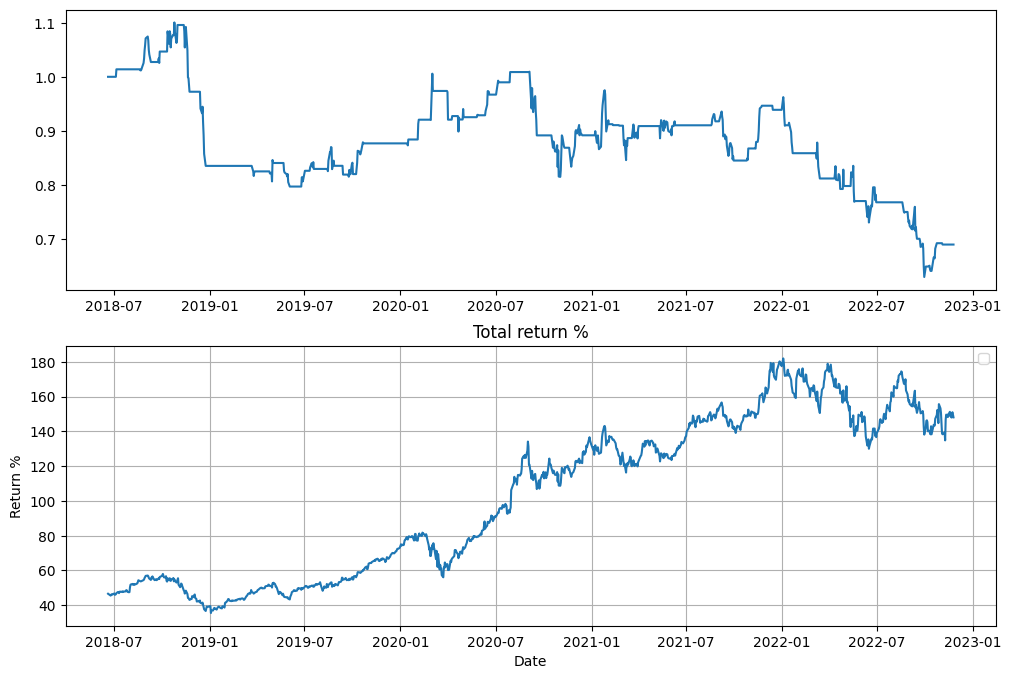

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import time



pd.set_option('mode.chained_assignment', None)

stock = 'AAPL'
period = 'max'
start_date =  '2018-06-20'
end_date = '2022-11-28'
interval = '1d'
overbought=90
oversold=10
volumeaverage=30
volumemax=200

def get_stock_data(stock,startdate,enddate,period,interval):
    ticker = stock
    yf.pdr_override()
    df = yf.download(tickers=stock, start=startdate, end=enddate, interval=interval,period=period)
    df.reset_index(inplace=True)
    df['date'] = df['Date'].dt.date
    df['index']=df.index

    return df

def volume_strategy(df,over_bought,over_sold,volume_average,volume_max):
    start_time=time.time()
    df['Buy Unit']= (df['Close']-df['Low'])/(df['High']-df['Low'])
    df['Sell Unit']= (df['High']-df['Close'])/(df['High']-df['Low'])

    volume_signals=pd.DataFrame()
    volume_signals['Index']=df.index
    volume_signals['Buy Volume']=df['Volume'] * df['Buy Unit']
    volume_signals['Sell Volume']=df['Volume'] * df['Sell Unit']

    volume_signals['Buy Sell Ratio']=100* (volume_signals['Buy Volume']/ (volume_signals['Buy Volume']+volume_signals['Sell Volume']))

    volume_signals['Buy']=np.where(volume_signals['Buy Sell Ratio']<=over_sold,1,0)
    volume_signals['Sell']=np.where(volume_signals['Buy Sell Ratio']>=over_bought,1,0)
    volume_signals.to_csv('volume_signals.csv')
    SellVector=volume_signals[['Sell', 'Index','Buy']].to_numpy()
    #print(volume_signals[['Buy','Sell']])

    a=np.array(np.where(volume_signals['Sell'].diff()==1))

    if len(a[0])%2!=0:
        a=np.delete(a[0],-1)


    try:
        Split1_SellDatesVector=np.split(a,len(a)/2)
        Split2_SellDatesVector=np.split(a[1:-1],((len(a)-2))/2)
    except:
        Split1_SellDatesVector=np.split(a[0],len(a[0])/2)
        Split2_SellDatesVector=np.split(a[0][1:-1],((len(a[0])-2))/2)
    #print(Split2_SellDatesVector)
    #print(Split1_SellDatesVector)
    #Blir faktiskt ett litet fel här men spelar ingen roll i det långa loppet om en är fel.
    buydate_array=np.array([0])
    selldate_array=np.array([0])

    for x in range(len(Split1_SellDatesVector)):

        Splitted_Sell_Dates1=np.split(SellVector,Split1_SellDatesVector[x])
        Splitted_Sell_Dates1.pop(0)
        Splitted_Sell_Dates1.pop(1)

        two_axis=np.delete(Splitted_Sell_Dates1[0],0,axis=1)

        test=np.sum(two_axis, axis=0)
        if test[1]!=0:
            buynumber=np.where(two_axis[:,1]==1)[0][0]
            buydate=two_axis[buynumber][0]
            selldate=two_axis[-1][0]
            a=np.array([buydate])
            b=np.array([selldate])
            a += 2 # Ändra delay här! Ändra både a och b
            selldate_array=np.append(selldate_array,b+1, axis=0)
            buydate_array=np.append(buydate_array,a,axis=0)

        try:
            Splitted_Sell_Dates2=np.split(SellVector,Split2_SellDatesVector[x])
            Splitted_Sell_Dates2.pop(0)
            Splitted_Sell_Dates2.pop(1)
            two_axis2=np.delete(Splitted_Sell_Dates2[0],0,axis=1)
            test=np.sum(two_axis2,axis=0)

            if test[1]!=0:

                buynumber=np.where(two_axis2[:,1]==1)[0][0]
                buydate=two_axis2[buynumber][0]
                selldate=two_axis2[-1][0]
                a=np.array([buydate])
                b=np.array([selldate])
                #print(a)
                a += 1 # Ändra delay här! Ändra både a och b
                #print(a)
                selldate_array=np.append(selldate_array,b+1, axis=0)
                buydate_array=np.append(buydate_array,a,axis=0)
        except:pass

    #print(buydate_array,selldate_array)
    print(time.time()-start_time)
    return buydate_array,selldate_array,volume_signals

def portfolio(df,buydate,selldate):
    portfolios=pd.DataFrame()
    portfolios['price']=df['Close']
    portfolios['pricec']=portfolios['price'].pct_change()

    portfolios['Buydates']=np.where(df['index'].isin(buydate),1,0)

    portfolios['Selldates']=np.where(df['index'].isin(selldate),-1,0)

    portfolios['Important Dates']=portfolios['Selldates']+portfolios['Buydates']
    portfolios['Important Dates']=portfolios[['Important Dates']].cumsum()
    portfolios['Important Dates'].to_csv('importantdates.csv')


    #kolla index

    portfolios['Price change buy']=np.where(portfolios['Important Dates']==1,1+portfolios['pricec'],1).cumprod()


    return portfolios['Price change buy']

def drawdown(portfolios,df):
    previous_peaks = portfolios.cummax()

    drawdown = (portfolios - previous_peaks)/previous_peaks

    print('---'*20)
    print(f'{100*drawdown.min()}%')
    print('---'*20)

    previous_peaks2 = df['Close'].cummax()

    drawdown2 = (df['Close'] - previous_peaks2)/previous_peaks2

    print('---'*20)
    print(f'{100*drawdown2.min()}%')
    print('---'*20)

    return
def graph(df,pf,vs):
    fig=plt.figure(figsize=[12,8])

    dx=fig.add_subplot(211)
    #ax=fig.add_subplot(212)

    dx.plot(df['Date'],pf)
    #ax.plot(df['Date'],df['Close'])
    #ax.plot(vs['Sell Volume'])
    #ax.plot(vs['Buy Volume'])
    cx=fig.add_subplot(212)
    cx.plot(df['Date'],df['Close'])
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Return %')
    plt.title('Total return %')
    plt.show()
df = get_stock_data(stock,start_date,end_date,period,interval)
bd,sd,vs=volume_strategy(df,overbought,oversold,volumeaverage,volumemax)

pf=portfolio(df,bd,sd)
drawdown(pf,df)
graph(df,pf,vs)

This strategy works well when not in a trend, otherwise it fails dramatically. Noticable is that the system works well for the reversed parameters. One should frawn upon changing anything after backtesting, but since we have spare data for our strategy, we might as well, in the future, change the signals and use that as our strategy.